# Learning CStree using Gibbs sampler

In [1]:
import sys
import logging
import random

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq

import pandas as pd
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
import pp

%load_ext autoreload
%autoreload 2
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)

/home/f/l/flrios/NOBACKUP/flrios/miniconda3/envs/cstrees/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sample a random CStree

In [649]:
np.random.seed(22)
random.seed(22)
p = 4
cards = [2] * p # state space

t = ct.sample_cstree(cards, max_cvars=2, prob_cvar=0.5, prop_nonsingleton=1)
t.labels = ["a", "b", "c", "d", "e"][:p]

#t.plot()
t.sample_stage_parameters(alpha=2) # optimize parameters 
#t.plot(full=True)

In [650]:
t.sample(10)

Creating tree on the fly while sampling to save space when allowing for singleton stages.


,a,b,c,d
0,2,2,2,2
1,1,0,1,1
2,1,0,0,1
3,1,0,1,1
4,1,1,1,0
5,1,0,1,1
6,1,0,1,1
7,1,0,1,1
8,1,0,0,1
9,1,0,0,1


Use plot(full=True) to draw the full tree.


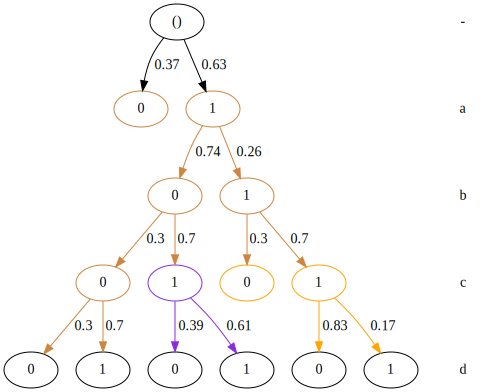

In [651]:
t.plot()

In [652]:
t.sample(5)

,a,b,c,d
0,2,2,2,2
1,0,0,1,1
2,0,0,1,1
3,1,1,1,0
4,1,1,1,0
5,1,0,0,0


Use plot(full=True) to draw the full tree.


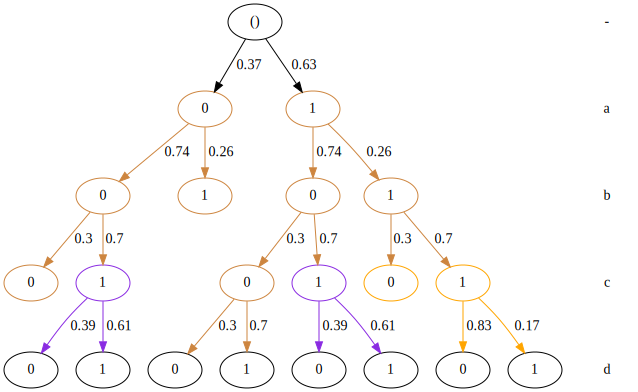

In [653]:
t.plot()

In [654]:
agraphs= t.to_minimal_context_agraphs()
print(len(agraphs))

2


X1=1


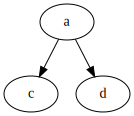

In [655]:
keys = list(agraphs.keys())
print(keys[1])
agraphs[keys[1]]


In [656]:
np.random.seed(6)
x = t.sample(2000)
x

,a,b,c,d
0,2,2,2,2
1,1,0,1,0
2,0,0,1,1
3,0,0,1,1
4,1,0,1,1
...,...,...,...,...
1996,1,0,1,0
1997,1,0,1,0
1998,0,0,0,1
1999,1,0,0,1


In [657]:
x.to_csv("data.csv", index=False)

## Create the score tables

In [658]:
pcgraph = pc(x[1:].values, 0.05, "chisq", node_names=x.columns)
#print(pcgraph.find_adj()) # can take such as input. or an adjmat

poss_cvars = {l:[] for l in x.columns}
for (i, j) in pcgraph.find_adj():
    poss_cvars[x.columns[i]].append(x.columns[j])
#poss_cvars


Depth=1, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 120.91it/s] 


In [659]:
#poss_cvars = {l:random.sample(list(set(t.labels) - {l}) ,k=3) for l in t.labels}
#poss_cvars = None
print(poss_cvars)

{'a': [], 'b': ['d'], 'c': ['d'], 'd': ['b', 'c']}


In [660]:
score_table, context_scores, context_counts = sc.order_score_tables(x, 
                                                                    max_cvars=2, 
                                                                    alpha_tot=1.0,
                                                                    method="BDeu",
                                                                    poss_cvars=poss_cvars)

Order score tables: 100%|██████████| 4/4 [00:00<00:00, 2631.31it/s]


## The order score tables

In [661]:
pp(score_table)

{'max_cvars': 2,
 'poss_cvars': {'a': [], 'b': ['d'], 'c': ['d'], 'd': ['b', 'c']},
 'scores': {'a': {'None': -1304.5854583127348},
            'b': {'None': -1136.626778924429, 'd': -941.772907416441},
            'c': {'None': -1227.9873895937626, 'd': -1228.1488207510674},
            'd': {'None': -1389.681339240829,
                  'b': -1194.827467732841,
                  'b,c': -1195.3008282540195,
                  'c': -1389.8427703981336}}}


## The context score tables

In [662]:
pp(context_scores)

{'cards': {'a': 2, 'b': 2, 'c': 2, 'd': 2},
 'max_cvars': 2,
 'poss_cvars': {'a': [], 'b': ['d'], 'c': ['d'], 'd': ['b', 'c']},
 'scores': {'a': {'None': -1303.199163951615},
            'b': {'None': -1135.240484563309,
                  'd=0': -661.1873056706181,
                  'd=1': -278.7938422765948},
            'c': {'None': -1226.6010952326428,
                  'd=0': -565.2063772236822,
                  'd=1': -662.680668827506},
            'd': {'None': -1388.2950448797092,
                  'b=0': -973.5600535713029,
                  'b=0,c=0': -278.3356694106516,
                  'b=0,c=1': -695.6902076101094,
                  'b=1': -219.47565469231006,
                  'b=1,c=0': -68.00436687868722,
                  'b=1,c=1': -155.35571601548432,
                  'c=0': -415.56858833312776,
                  'c=1': -974.0124073651264}}}


## Run the Gibbs sampler

In [663]:
orders, scores = ctl.gibbs_order_sampler(5000, score_table)

initial order: ['b', 'd', 'a', 'c']
initial score: -4864.188525721072


Gibbs order sampler: 100%|██████████| 5000/5000 [00:00<00:00, 5356.26it/s]


### Trajectory score plots

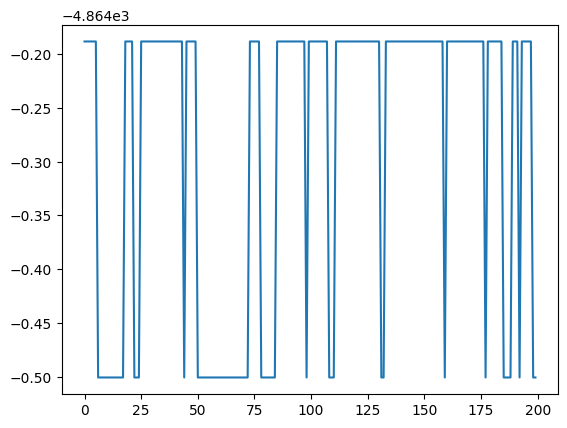

In [664]:
plt.plot(scores[:200])

### Order position plots

Get the individual variables locations in the order and plot them

In [665]:
var_positions = {var: [x.index(var) for x in orders] for var in orders[0]}
var_positions["iteration"] = list(range(len(orders))) 
plotdf = pd.DataFrame(var_positions)

<Axes: xlabel='iteration'>

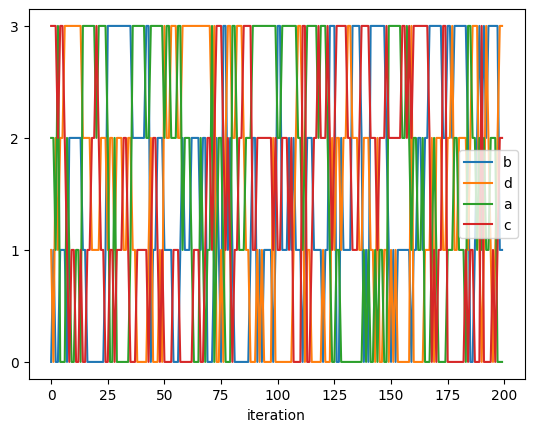

In [666]:
plotdf[:200].plot(x = "iteration", y = range(p), yticks=range(len(orders[0])))

### Get the maximal scoring order

In [667]:
max(scores)
maxi = scores.index(max(scores))
maporder = orders[maxi]
maporder

['b', 'd', 'a', 'c']

### Get the maximal scoring CStree for the order

In [668]:
opttree = ctl._optimal_cstree_given_order(maporder, context_scores)

In [669]:
opttree.to_df()

,b,d,a,c
0,2,2,2,2
1,0,-,-,-
2,1,-,-,-
3,*,*,-,-
4,*,*,*,-
5,-,-,-,-


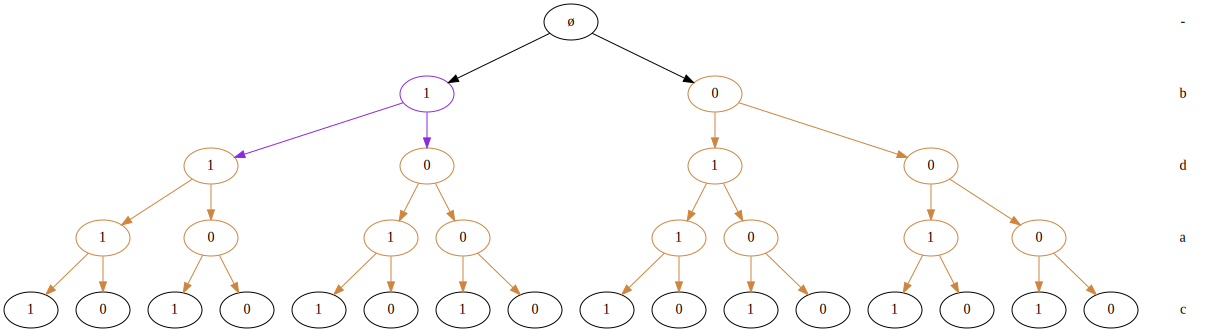

In [670]:
opttree.plot(full=True)

## Estimate the CStree parameters

In [671]:
opttree.estimate_stage_parameters(x, alpha_tot=2.0, method="BDeu")

opttree.to_df(write_probs=True)


,b,d,a,c,PROB_0,PROB_1
0,2,2,2,2,NaN,NaN
1,0,-,-,-,0.352174,0.647826
2,1,-,-,-,0.847140,0.152860
3,*,*,-,-,0.353646,0.646354
4,*,*,*,-,0.300699,0.699301
5,-,-,-,-,0.746753,0.253247


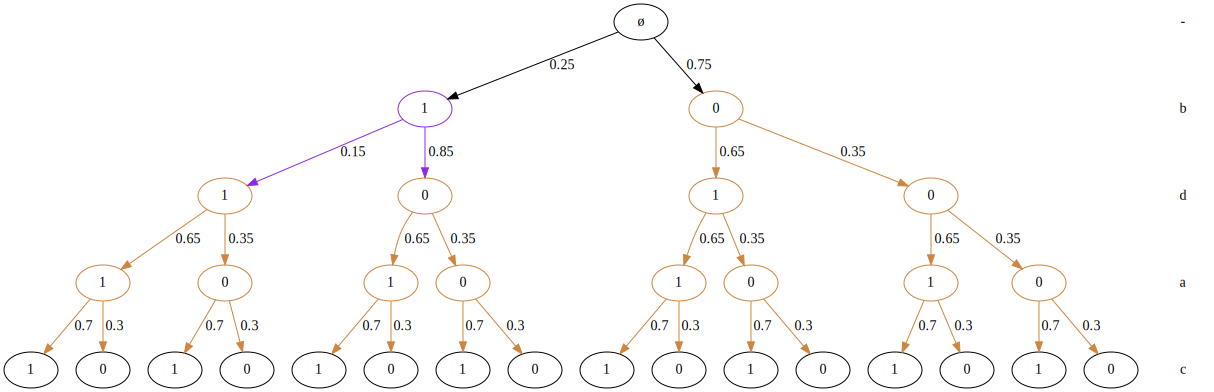

In [672]:
opttree.plot(full=True)

## Plot the DAG representation

In [673]:
agraphs= opttree.to_minimal_context_agraphs()
len(agraphs)

1

None


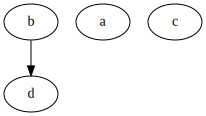

In [674]:
keys = list(agraphs.keys())
print(keys[0])
agraphs[keys[0]]
